In [1]:
import argparse
import torch
import torch.nn as nn
import dgl
import torch.optim as optim
from dgl.dataloading import MultiLayerFullNeighborSampler, EdgeDataLoader
from dgl.dataloading.negative_sampler import Uniform
import numpy as np
import pandas as pd
import itertools
import os
import tqdm
import matplotlib.pyplot as plt
from dgl import save_graphs, load_graphs
import dgl.function as fn
import torch.nn.functional as F
from dgl.nn.pytorch import GraphConv, SAGEConv, HeteroGraphConv
from dgl.utils import expand_as_pair
from collections import defaultdict
import torch as th
import dgl.nn as dglnn
from dgl.data.utils import makedirs, save_info, load_info
from sklearn.metrics import roc_auc_score
import gc
from thefuzz import fuzz
from thefuzz import process
import time
import re

gc.collect()

18

In [2]:
file1 = '~/Downloads/harvard-index-collectors.csv'  ## macOS file location, harvard index collector
harvard_data = pd.read_csv(file1,chunksize=10000,encoding='utf-8',on_bad_lines='skip',engine='python')
harvard_data = pd.concat(harvard_data)
harvard_columns = harvard_data.columns.tolist()
harvard_data.rename(columns={harvard_columns[8]:'labelName'}, inplace=True) ## to avoid special character in colNames

harvard_columns = harvard_data.columns.tolist()   ## load content into list
harvard_data.head()

,Unnamed: 0.1,Unnamed: 0,id,Name,First date collected,Remarks,ASA Botanist ID,GUID,labelName,Full Name,...,First date received,End Date,Specialty,URL,Last date received,Geography,Vernacular name,Image,Agent type,Team Members:
0,0,0.0,47342,"Hepp, R.",1946,[collector note: SGO],147721 botanist,http://purl.oclc.org/net/edu.harvard.huh/guid/...,R. Hepp,"Hepp, R.",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1.0,14911,"Palazzi, Andrea",NaN,[collector note: Herbarium (Piedmont (Italy): TO],114969 botanist,http://purl.oclc.org/net/edu.harvard.huh/guid/...,A. Palazzi,"Palazzi, Andrea",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,2.0,29488,"Nicholls, Robert",NaN,"[collector note: BM-SL, OXF.]",129688 botanist,http://purl.oclc.org/net/edu.harvard.huh/guid/...,Robert Nicholls,"Nicholls, Robert",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,3.0,44660,"Hosie, R. C.",1937,"[collector note: Ontario, Algoma Dist., Thunde...",145012 botanist,http://purl.oclc.org/net/edu.harvard.huh/guid/...,R. C. Hosie,"Hosie, R. C.",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,4.0,10131,"Lohman, M. L.",NaN,[collector note: Type collection: FH],110149 botanist,http://purl.oclc.org/net/edu.harvard.huh/guid/...,M. L. Lohman,"Lohman, M. L.",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
file2 = '~/Downloads/wikidata-collectors-230615.csv'  ## macOS file location, wikipedia collector

wiki_data = pd.read_csv(file2,chunksize=10000,encoding='utf-8',on_bad_lines='skip',engine='python')
wiki_data = pd.concat(wiki_data)
wiki_columns = wiki_data.columns.tolist()   ## load content into list
wiki_data.head()

,id,label,institutions,dateOfBirth,ISNI,countryOfCitizenshipISO,countryOfCitizenship,aliases,bionomia,dateOfDeath,sexOrGender,VIAF,IPNI,harvardIndex,authorAbbrv,birthName
0,Q100142069,Frida Eggens,NaN,NaN,NaN,['SE'],['Q34'],['Eggens'],NaN,NaN,female,NaN,20045232-1,NaN,Eggens,NaN
1,Q100146795,Elizabeth Harrison,NaN,+1792-12-00T00:00:00Z,NaN,['GB'],"['Q161885', 'Q174193']","['Mrs Arnold Harrison', 'Mrs A. H.']",Q100146795,+1834-01-05T00:00:00Z,female,NaN,NaN,NaN,NaN,NaN
2,Q100149196,Russell Cox,['9cfe8cbf-35ff-4d93-b932-cb05d91b7922'],NaN,NaN,NaN,NaN,[],0000-0001-5149-1709,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Q100152296,Alda Pereira da Fonseca,NaN,+1882-00-00T00:00:00Z,NaN,['BR'],['Q155'],[],NaN,NaN,female,NaN,NaN,NaN,NaN,NaN
4,Q100156193,Laurence Henry Millener,['c3d8b0e8-4b2b-4692-bfa7-73117d189508'],+1914-04-01T00:00:00Z,NaN,['NZ'],['Q664'],"['L. H. Millener', 'Laurie Henry Millener', 'L...",Q100156193,+2000-00-00T00:00:00Z,male,NaN,NaN,NaN,NaN,NaN


In [12]:
wiki_data['dateOfBirth'] = convert_date2year(wiki_data,'dateOfBirth')
wiki_data['dateOfDeath'] = convert_date2year(wiki_data,'dateOfDeath')

In [13]:
harvard_data['combinedSpecialty'] = combine_specialty(harvard_data)
harvard_data['combinedGeography'] = combine_geography(harvard_data)

a, b = get_author_collector_notes(harvard_data, 'Remarks')
harvard_data['authorNotes'] = a
harvard_data['collectorNotes'] = b
harvard_data['authorNotes'] = extract_herbariums(harvard_data,'authorNotes')
harvard_data['collectorNotes'] = extract_herbariums(harvard_data,'collectorNotes')

In [15]:
cols_to_drop = ['Unnamed: 0.1','Unnamed: 0','Geography Author', 'Geography Collector', 'Geography Determiner', 
                  'Geography','Specialty Author', 'Specialty Collector', 'Specialty Determiner', 'Specialty',
                  'Remarks',]
harvard_data.drop(cols_to_drop, axis=1, inplace=True)

In [16]:
wiki_data['harvardIndex'] = pd.to_numeric(wiki_data['harvardIndex'],errors='coerce') ## wrap wiki id to int64

## Merging two dataframe
result = pd.merge(wiki_data, harvard_data, how='outer', on=None, left_on='harvardIndex', right_on='id',
                  left_index=False, right_index=False, sort=False,
                  suffixes=('_wiki', '_harvard'), copy=False, indicator=False)

                            sum
collectorNotes           114306
id_harvard               114306
authorNotes              114306
combinedGeography        114306
combinedSpecialty        114306
Name                     114302
GUID                     113019
labelName                106967
Full Name                103786
ASA Botanist ID           87208
id_wiki                   71988
aliases                   71988
label                     71740
Citation as Collector     67603
authorAbbrv               53828
IPNI                      53822
sexOrGender               50176
Variant name              47302
B & P Author Abbrev.      40899
Author name               39349
dateOfBirth               38647
Citation as Author        37269
Date of birth             34251
Holdings                  33528
Collections in            33528
harvardIndex              33411
First date collected      33291
dateOfDeath               27032
countryOfCitizenship      25364
VIAF                      23591
countryO

<AxesSubplot:title={'center':'Merged Data'}>

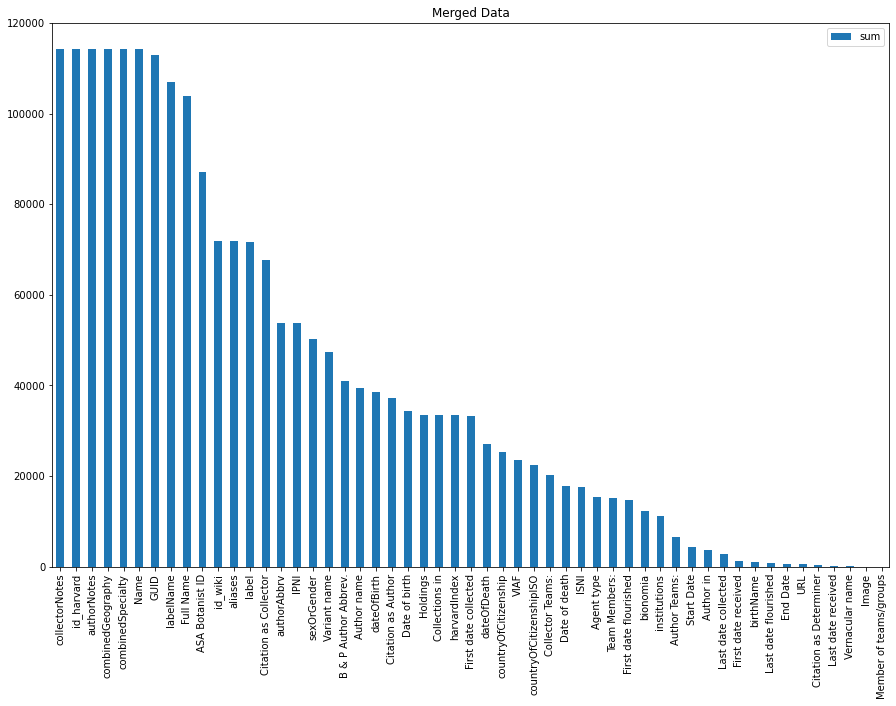

In [17]:
distribution = get_distribution(result, result.columns.tolist())
temp = distribution.T.sort_values(by=['sum'], ascending=False)
print(temp)
temp.plot.bar(figsize=(15,10), title = 'Merged Data')

In [4]:
# Method to compute and plot the data distribution of a given dataframe
'''
Example:
distribution = get_distribution(wiki_data, wiki_columns)
temp = distribution.T.sort_values(by=['sum'], ascending=False)
print(temp)
temp.plot.bar(figsize=(15,10), title = 'WikiData')
'''
def get_distribution(data, col):
    sum_count = 0
    data_distribution = {} ## a dictionary to store the distribution of individual entity
    data_distribution_sum = pd.DataFrame(columns = col, index=['sum'])
    for (columnName, columnData) in data.iteritems():
        temp = data[columnName].value_counts()
        data_distribution_sum.at['sum', columnName]=sum(temp)
    return data_distribution_sum

In [5]:
'''
# this function will remove all special charaters -- including spaces
# used process_time() for evaluation
Example:
newCol = remove_spec_in_col(wiki_data,'aliases')
'''
# Remove square blankets auto generated during data alignment process
def clean_text(text): # fb
    text = text.replace('[', '').replace(']','').replace("'", '')
    return text

def remove_spec_in_col(df, col):
    newCol = []
    for index, rowValue in df[col].iteritems():
        if pd.notnull(rowValue):
            newCol.append(clean_text(rowValue))
        else:
            newCol.append(np.nan)
    return newCol


In [6]:
# Replace empty list as np.nan
def remove_empty(df, col):
    newCol = []
    for index, rowValue in df[col].iteritems():
        if not rowValue:
            newCol.append(np.nan)
        else:
            newCol.append(rowValue)
    return newCol

In [7]:
'''
For Harvard Index data preprocessing
Example:
text1 = "[author note: Types at: MT] [collector note: col. with M. St-Arnaud; MT; BO]"
text2 = "[collector note: Herbarium (Piedmont (Italy): TO]"
text3 = "[collector note: SAFB] plant pathologist; short biography and photo: Can. J. Plant Pathol. Vol. 28: S21-S22. 2006."
text4 = "[collector note: BM-SL, OXF.]"
text5 = "[collector note: Herbarium and types, US, additional m,erial , B, C, DBN, GH, K, MIN, MO, NA, NY, PH"
text = "[author note: LE; temperate Asian Polygonaceae] [collector note: LE] "
temp = text4.split("[")

s1 = get_author_notes(temp)
s2 = get_collector_notes(temp)
print("\nFunction version:")
print("author note: ", s1)
for i in s1: print("\nHerbarium List: ", get_herbarium_codes(i))
print("collector note: ", s2)
for i in s2: print("\nHerbarium List: ", get_herbarium_codes(i))

a, b = get_author_collector_notes(harvard_data, 'Remarks')

b = harvard_data[['id', 'collector note']].copy()
b['collector note'] = extract_herbariums(b,'collector note')
'''
            
def get_author_notes(string):
    authorNotes = []
    for s in string:
        # s = clean_text(s)
        # authorNotes.append(s.partition("author note: ")[2].partition(" ")[0].replace(";", ''))
        authorNotes.append(s.partition("author note: ")[2].partition("]")[0].replace(";", ',').replace(":", ',').replace("(",",").replace(")",",").replace("at",","))
    authorNotes = list(filter(None, authorNotes))
    return authorNotes

def get_collector_notes(string):
    collectorNotes = []
    for s in string:
        # s = clean_text(s)
        # collectorNotes.append(s.partition("collector note: ")[2].partition(" ")[0].replace(";", ''))
        collectorNotes.append(s.partition("collector note: ")[2].partition("]")[0].replace(";", ',').replace(":", ',').replace("(",",").replace(")",",").replace("at",","))
    collectorNotes = list(filter(None, collectorNotes))
    return collectorNotes

def get_author_collector_notes(df, col):
    authorNoteCol = []
    collectorNoteCol = []
    for index, rowValue in df[col].iteritems():
        if pd.notnull(rowValue):
            string = rowValue.split("[")
            authorNoteCol.append(get_author_notes(string))
            collectorNoteCol.append(get_collector_notes(string))
        else:
            authorNoteCol.append([]) # use empty to reduce runtime exception while condition checking
            collectorNoteCol.append([])
    return authorNoteCol, collectorNoteCol

# Functions to extract the herbarium institution codes from Remarks in Harvard Index
def get_herbarium_codes(string):
    herbarium_codes = []
    for s in string.split(","):
        if s.isupper():
            herbarium_codes.append(re.sub('[^A-Z]', ',', s).replace(",",""))
    return herbarium_codes

def extract_herbariums(df, col):
    newCol = []
    for index, rowValue in df[col].iteritems():
        if rowValue:
            temp = []
            for i in rowValue: 
                temp += get_herbarium_codes(i)
            newCol.append(temp)
        else:
            newCol.append([])
    return newCol

In [8]:
'''
Return the cleaned year value of Wikidata
Example:
new_df['dateOfBirthYear'] = convert_date2year(wiki_data,'dateOfBirth')
'''
def get_year(date_str):
    # Remove + sign
    if date_str[0] == '+':
        date_str = date_str[1:]
    return int(date_str[0:4])

def convert_date2year(df, col):
    newCol = []
    for index, rowValue in df[col].iteritems():
        if pd.notnull(rowValue):
            newCol.append(get_year(rowValue))
        else:
            newCol.append(np.NaN)
    return newCol

# Not used in the data cleaning process
def get_timestamp(date_str):
    # Probably not necessary
    date_str = date_str.strip()
    # Remove + sign
    if date_str[0] == '+':
        date_str = date_str[1:]
    # Remove missing month/day
    date_str = date_str.split('-00', maxsplit=1)[0]
    # Parse date
    dt = np.datetime64(date_str)
    # As Unix timestamp (choose preferred datetype)
    return dt.astype('<M8[s]').astype(np.int64)

In [9]:
'''
For Harvard Index data preprocessing
Example:
temp = harvard_data[['id','Name','Specialty Author', 'Specialty Collector', 'Specialty Determiner', 'Specialty']].copy()
temp['combine_specialty'] = combine_specialty(temp)
# temp['combine_specialty'].value_counts().index.tolist()
'''
# Extract specialty areas of collectors
def combine_specialty(df):
    cols = ['Specialty Author', 'Specialty Collector', 'Specialty Determiner', 'Specialty']
    newCol = df[cols].apply(lambda row: ','.join(row.dropna().unique()), axis=1)
    for index, rowValue in newCol.iteritems():
        if pd.notnull(rowValue):
            newCol[index] = set(clean_text(rowValue).replace('And',',').replace(' and ',',').replace(' ','').split(','))
        else:
            newCol[index] = np.nan
    return newCol

In [10]:
'''
For Harvard Index data preprocessing
Example:
temp = harvard_data[['id','Name','Geography Author', 'Geography Collector', 'Geography Determiner', 'Geography']].copy()
temp['combine_geography'] = combine_geography(temp)
# temp['combine_geography'].value_counts().index.tolist()
'''
# Extract geography locations and travel history related to collectors
def combine_geography(df):
    cols = ['Geography Author', 'Geography Collector', 'Geography Determiner', 'Geography']
    newCol = df[cols].apply(lambda row: ','.join(row.dropna().unique()), axis=1)
    for index, rowValue in newCol.iteritems():
        if pd.notnull(rowValue):
            newCol[index] = set(clean_text(rowValue).replace('\xa0 ','').split(','))
        else:
            newCol[index] = np.nan
    return newCol

In [11]:
'''
For Combining Wikidata and Harvard Index data
Example:
wiki_data['harvardIndex'] = return_numeric(wiki_data, 'harvardIndex')

# But it's the same as the below inbuilt function
wiki_data['harvardIndex'] = pd.to_numeric(wiki_data['harvardIndex'],errors='coerce') ## wrap wiki id to int64
'''
# Helper function to extract numerical numbers from a data column
def return_numeric(df, col):
    newCol = []
    for index, rowValue in df[col].iteritems():
        if pd.notnull(rowValue):
            newCol.append(re.sub("[^0-9|.]", "", str(rowValue)))
        else:
            newCol.append(rowValue)
    return newCol